<a target="_blank" href="https://colab.research.google.com/github/cohere-ai/notebooks/blob/main/notebooks/Multimodal_Semantic_Search.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Multimodal Semantic Search

Multimodal semantic search enhances traditional search capabilities by leveraging both textual and visual modalities to deliver more accurate and contextually relevant results. 

This tutorial guides you through building a semantic search system over images. In this example, users will be able to enter textual search queries such as "Animals but preferably a gray cat" or "Nike shoes" and retrieve images that match the query.

It involves the following steps:

1. Load a dataset of images
2. Encode the images and embed them
3. Store the embeddings in a vector index
4. Ask queries against the index

## Setup

Let's install the required libraries and create a Cohere client.

In [1]:
! pip install -U cohere hnswlib -q

In [4]:
from PIL import Image
from IPython.display import display, HTML
import requests  # We can take this out once its in the SDK
import cohere
import base64
import hnswlib
import os

co = cohere.ClientV2(
    api_key="COHERE_API_KEY"
)  # Get your free API key: https://dashboard.cohere.com/api-keys

## Step 1: Load a dataset of images 

First, we load a small image dataset to be used for semantic search - the dataset contains a diverse set of images such as animals, ecommerce products, and stock charts.

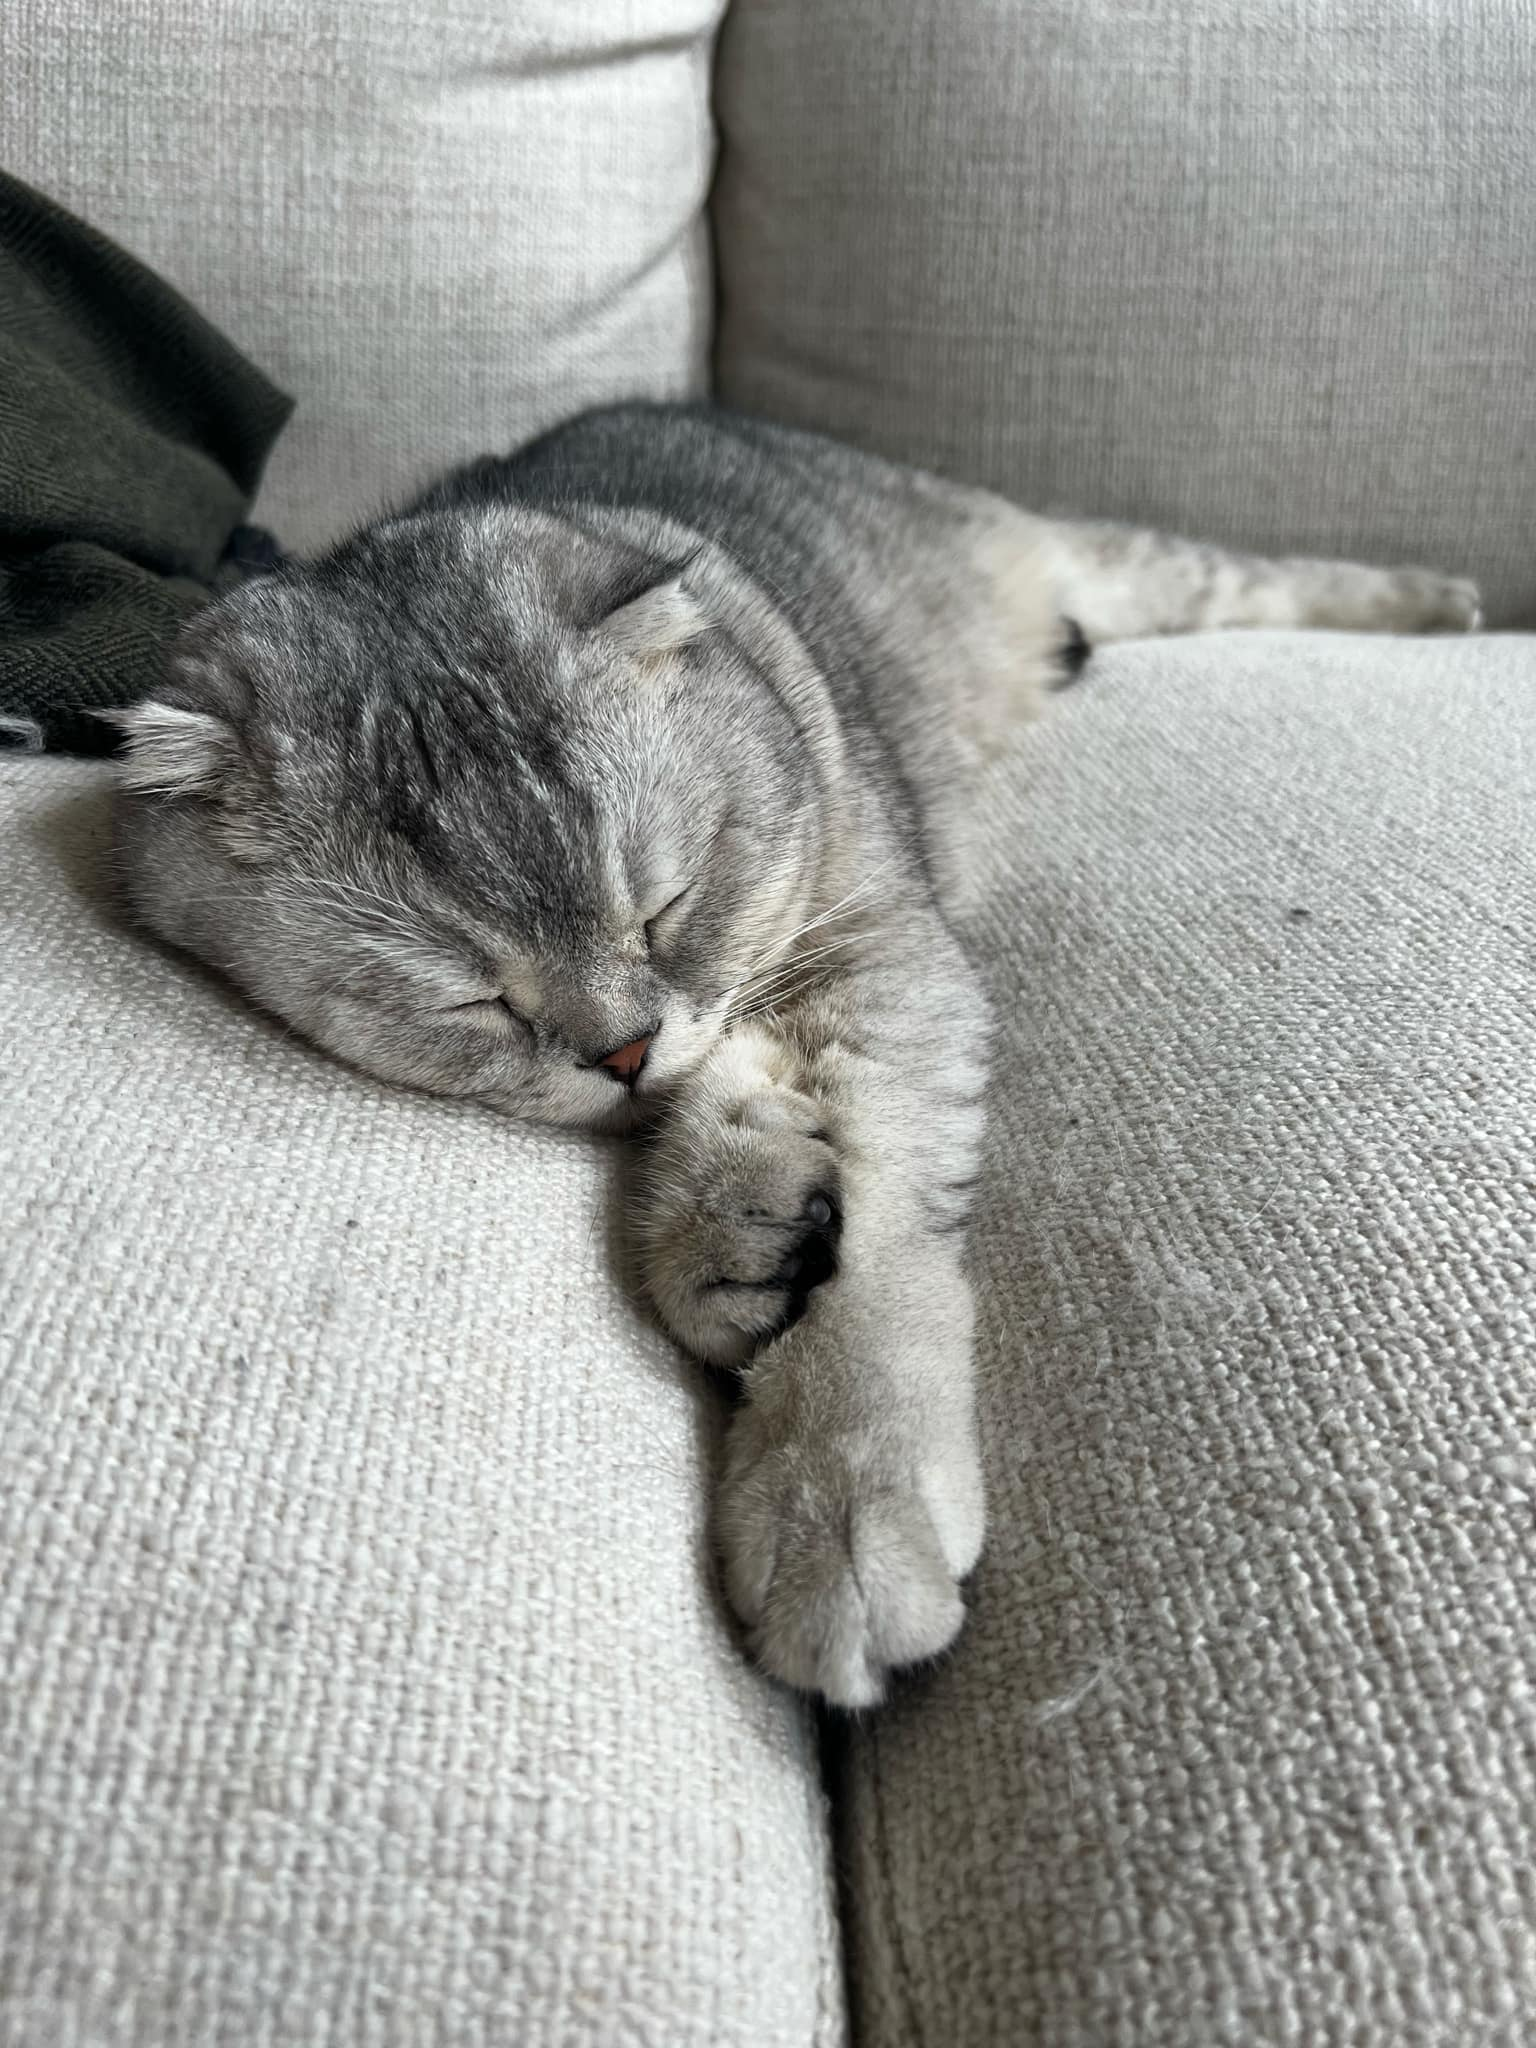

In [5]:
# We've prepared a small image dataset to be used for semantic search - the dataset contains a diverse set of images ranging from natural images to products

folder_path = "data/multimodal_semantic_search"
files = os.listdir(folder_path)

# Let's view a sample image:
file_path = os.path.join(folder_path, files[1])
img = Image.open(file_path)
display(img)

## Step 2: Encode the images and embed them

Next, we define a function to convert each image into a base64 Data URL and then call the Embed endpoint to generate the embeddings for each image.

In [6]:
# Define a function to convert each image into base64 Data URL and then call our embed model
def image_to_base64_data_url(image_path):

    with open(image_path, "rb") as f:
        enc_img = base64.b64encode(f.read()).decode("utf-8")
        enc_img = f"data:image/jpeg;base64,{enc_img}"

    response = co.embed(
        model="embed-multilingual-v3.0",
        images=[enc_img],
        input_type="image",
        embedding_types=["float"],
    )

    return response

## Step 3: Compute the embeddings and store in a vector index

Now, we'll compute the embeddings for each image and store the full response in a vector index using `hnswlib`.

In [9]:
# Embed Images and store the full response in an array
embeddings = []
file_paths = []

for file in files:
    file_path = os.path.join(folder_path, file)
    res = image_to_base64_data_url(file_path)
    file_paths.append(file_path)
    embeddings.append(res.embeddings.float[0])

In [11]:
# Print one example item from the embedding_objects array
print(str(embeddings[0][:10])[:-1] + ", ...]")

[0.016189575, 0.026306152, -0.048461914, 0.025924683, -0.0019521713, 0.008323669, 0.021987915, -0.049621582, -0.046813965, 0.045318604, ...]


## Step 3: Store the embeddings in a vector index


In [12]:
# Create the hnsw index
index = hnswlib.Index(space="cosine", dim=1024)
index.init_index(max_elements=len(embeddings), ef_construction=512, M=64)
index.add_items(embeddings, list(range(len(embeddings))))

## Step 4: Ask queries against the index

We can now ask queries against the index. First, let's build a function to retrieve the images given a query.

In [13]:
def retrieve_image(query):
    top_k = 5
    size = (200, 200)

    # Convert the query into embeddings
    query_emb = co.embed(
        texts=[query],
        model="embed-multilingual-v3.0",
        input_type="search_query",
        embedding_types=["float"],
    ).embeddings.float

    # Retrieve the initial results from your vector db
    res = index.knn_query(query_emb, k=top_k)
    doc_index = res[0][0]
    doc_scores = res[1][0]

    # Let's view the response image:
    print(
        f"The most relevant photo in the top {top_k} retreived images with a distance score of: {doc_scores[0]:.2f}"
    )
    img = Image.open(file_paths[doc_index[0]])
    img_resized = img.resize(size)
    display(img_resized)

    # For the full list of images grabbed:
    print("-" * 100)
    print("All top k images:")
    for x in range(0, len(doc_index)):
        print(f"Ranking of Relevance:{x+1} with a distance of: {doc_scores[x]:.2f}")
        img = Image.open(file_paths[doc_index[x]])
        img_resized = img.resize(size)
        display(img_resized)

Let's try with a first query about cats.

The most relevant photo in the top 5 retreived images with a distance score of: 0.45


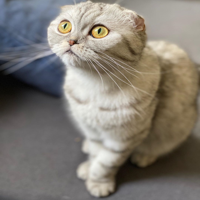

----------------------------------------------------------------------------------------------------
All top k images:
Ranking of Relevance:1 with a distance of: 0.45


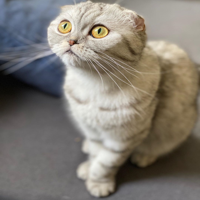

Ranking of Relevance:2 with a distance of: 0.47


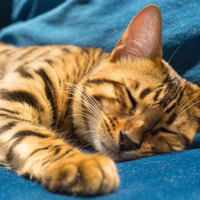

Ranking of Relevance:3 with a distance of: 0.47


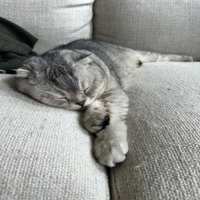

Ranking of Relevance:4 with a distance of: 0.49


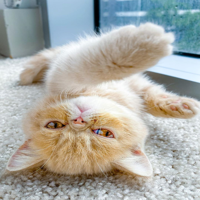

Ranking of Relevance:5 with a distance of: 0.50


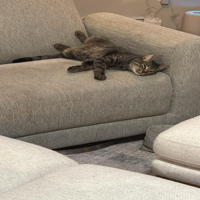

In [14]:
# Set these paramters and query your database
query = "Animals but preferably a gray cat"

retrieve_image(query)

The sample dataset also contains images from other domains such as ecommerce products and stock charts. Let's try a couple of queries to see how multimodal search can be useful in these domains.

Here we send a query about ecommerce products, such as "Nike shoes", and return the top 2 images that match the query.

In [15]:
def retrieve_image_top_k(query, top_k=2):
    size = (200, 200)

    # Convert the query into embeddings
    query_emb = co.embed(
        texts=[query],
        model="embed-multilingual-v3.0",
        input_type="search_query",
        embedding_types=["float"],
    ).embeddings.float

    # Retrieve the initial results from your vector db
    res = index.knn_query(query_emb, k=top_k)
    doc_index = res[0][0]
    doc_scores = res[1][0]

    # For the full list of images grabbed:
    print("-" * 100)
    print("All top k images:")
    for x in range(0, len(doc_index)):
        print(f"Ranking of Relevance:{x+1} with a distance of: {doc_scores[x]:.2f}")
        img = Image.open(file_paths[doc_index[x]])
        img_resized = img.resize(size)
        display(img_resized)

----------------------------------------------------------------------------------------------------
All top k images:
Ranking of Relevance:1 with a distance of: 0.34


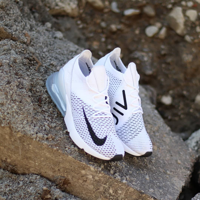

Ranking of Relevance:2 with a distance of: 0.35


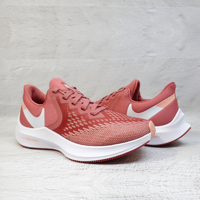

In [16]:
query = "Nike shoes"

retrieve_image_top_k(query)

And here is another query about stock charts.

----------------------------------------------------------------------------------------------------
All top k images:
Ranking of Relevance:1 with a distance of: 0.33


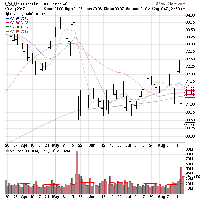

Ranking of Relevance:2 with a distance of: 0.48


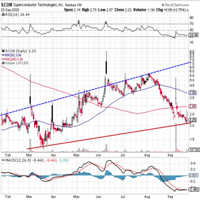

In [17]:
query = "Cisco stock chart"

retrieve_image_top_k(query)

# Conclusion

In this tutorial, we've built a multimodal semantic search system that retrieves images based on textual queries. We've demonstrated:

1. Loading and encoding a dataset of images
2. Creating and storing image embeddings
3. Building a vector index for efficient search
4. Querying the index with natural language

This system showcases the power of combining textual and visual modalities, enabling more intuitive and contextually relevant image retrieval. We've seen its effectiveness across diverse queries, from specific objects to abstract concepts.


